In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap, value_and_grad

import tensorflow_probability.substrates.jax as tfp

## Data with homoscedastic noise

In [251]:
# Homoscedastic noise
x = jnp.linspace(-10, 10, 50)
mu = 0
std = 5
key = jax.random.PRNGKey(5)
es = mu + std * jax.random.normal(key, (50,))
y = 10*x + 3 + es 

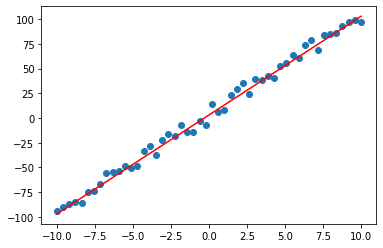

In [252]:
plt.plot(x, y, 'o')
plt.plot(x, 10*x +3  , 'r')
plt.show()

## Data with hetroscedastic noise

In [213]:
# Hetroscedastic noise
x = jnp.linspace(-10, 10, 50)
mu = 0
std = 5
key = jax.random.PRNGKey(0)
es = mu + std * jax.random.normal(key, (50,))
y = 9* x + es +  x * jax.random.normal(key, (50,))

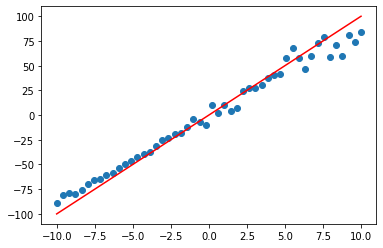

In [214]:
plt.plot(x, y, 'o')
plt.plot(x, 9*x + x, 'r')
plt.show()

## initializing parameters, forward pass, loss function

In [ ]:
seed = 15
key = jax.random.PRNGKey(seed)

In [216]:
def init_mlp_params(layer_widths, key):
    params = []
    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
      params.append(
          dict(weights=jax.random.normal(key = key, shape=(n_in, n_out)) ,
              biases=jax.random.normal(key = key, shape=(n_out,))
        )
    )

    return params

In [217]:
def forward(params, x):
    *hidden, last = params

    for layer in hidden:
        x = jax.nn.relu(jnp.dot(x, layer['weights']) + layer['biases'])

    return jnp.dot(x, last['weights']) + last['biases']

In [218]:
def loss_fn(theta, x, y):
    y_hat = forward(theta, x)
    return jnp.mean((y - y_hat) ** 2) # did mean to normalize and prevent overflow/ under flow

def logpdf(x, mu, sigma):
    res = -0.5 * jnp.log(2.0 * jnp.pi * sigma**2) - 0.5 * (x - mu)**2 / sigma**2
    return res

# loss using log of gaussian probability distribution function
def loss_l(theta, x, y):
    mu = forward(theta, x)
    variance = 1.0
    final_loss =  -jnp.mean(logpdf(y, mu, jnp.sqrt(variance))) # did mean to normalize and prevent overflow/ under flow
    return final_loss

# loss using tensor flow probability distribution 
def loss_tfp(theta, x, y):
    y_hat = forward(theta, x)
    variance = 1.0
    dist = tfp.distributions.Normal(y_hat, jnp.sqrt(variance))
    res = -jnp.mean(dist.log_prob(y)) # did mean to normalize and prevent overflow/ under flow
    return res



## update function

In [219]:
lr = 0.001
@ jit  
def update(params, x, y):
    loss = loss_fn(params, x,y)
    grads = jax.grad(loss_fn)(params, x, y)

    return loss, jax.tree_map(
        lambda p, g: p - lr * g, params, grads  
    )

In [220]:
@ jit
def update_l(params, x, y):
  loss = loss_l(params, x,y)
  grads = jax.grad(loss_l)(params, x, y)
  return loss , jax.tree_map(
    lambda p, g: p - lr * g, params, grads  
    )

In [221]:
@ jit
def update_tfp(params, x, y):
  loss = loss_tfp(params, x, y)
  grads = jax.grad(loss_tfp)(params, x, y)
  return loss , jax.tree_map(
    lambda p, g: p - lr * g, params, grads  
    )

plt.scatter(x, y, label= 'y_true')
plt.scatter(x, forward(params, x), label='y_hat')
plt.plot(x, x**2 + x, 'r', label= 'function')
plt.legend();

## training for homoscedastic noise

In [262]:
# Homoscedastic noise
x = jnp.linspace(-10, 10, 100).reshape(100,1)
mu = 0
std = 5
key = jax.random.PRNGKey(5)
es = mu + std * jax.random.normal(key, (100,1))
y = x **2 + es + x
# y =3 + 10 * x + es

### for loss using log pdf  

In [263]:

params = init_mlp_params([1, 10, 10, 1], key)

print(jax.tree_map(lambda x:x.shape, params))
num_epochs = 500
loss_list = []

# using full batch Gradient descent

for _ in range(num_epochs):
    loss, params = update_l(params, x, y)
    loss_list.append(loss)

[{'biases': (10,), 'weights': (1, 10)}, {'biases': (10,), 'weights': (10, 10)}, {'biases': (1,), 'weights': (10, 1)}]


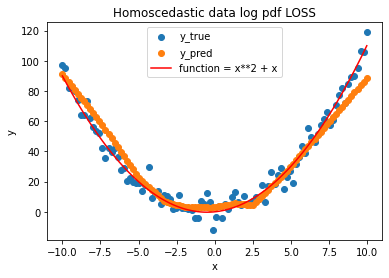

In [264]:
plt.scatter(x, y, label='y_true')
plt.scatter(x, forward(params, x), label='y_pred')
plt.plot(x, x**2 + x, 'r', label= 'function = x**2 + x')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Homoscedastic data log pdf LOSS')
plt.show()

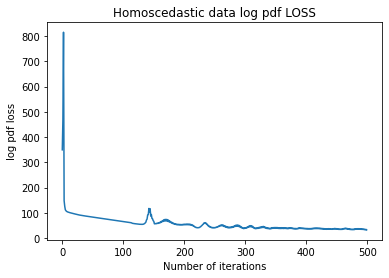

In [265]:
epo_list = [i for i in range(len(loss_list))]
plt.plot(epo_list, loss_list)
plt.xlabel('Number of iterations')
plt.ylabel('log pdf loss')
plt.title('Homoscedastic data log pdf LOSS')
plt.show()

### for tfp loss

In [266]:
params = init_mlp_params([1, 10, 10, 1], key)

print(jax.tree_map(lambda x:x.shape, params))
num_epochs = 500
loss_list = []

# using full batch Gradient descent
for _ in range(num_epochs):
    loss, params = update_tfp(params, x, y)
    loss_list.append(loss)

[{'biases': (10,), 'weights': (1, 10)}, {'biases': (10,), 'weights': (10, 10)}, {'biases': (1,), 'weights': (10, 1)}]


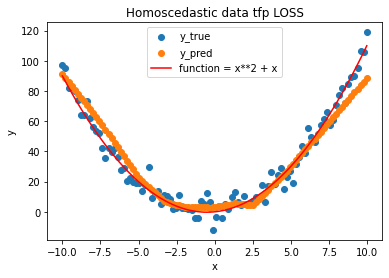

In [267]:
plt.scatter(x, y, label='y_true')
plt.scatter(x, forward(params, x), label='y_pred')
plt.plot(x, x**2 + x, 'r', label= 'function = x**2 + x')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Homoscedastic data tfp LOSS')
plt.show()

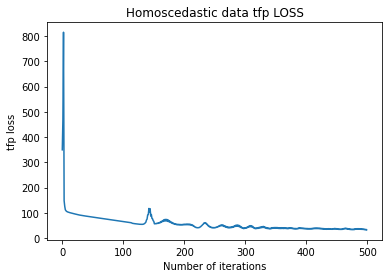

In [268]:
epo_list = [i for i in range(num_epochs)]
plt.plot(epo_list, loss_list)
plt.xlabel('Number of iterations')
plt.ylabel('tfp loss')
plt.title('Homoscedastic data tfp LOSS')
plt.show()

## training for hetroscedastic noise

In [230]:
# Hetroscedastic noise
x = jnp.linspace(-10, 10, 100).reshape(100,1)
mu = 0
std = 5
key = jax.random.PRNGKey(0)
es = mu + std * jax.random.normal(key, (100,1))
y = x **2 + es +  x * jax.random.normal(key, (100,1))


### for log pdf

In [233]:

params = init_mlp_params([1, 10, 10, 1], key)

print(jax.tree_map(lambda x:x.shape, params))
num_epochs = 500
loss_list = []
for _ in range(num_epochs):
    loss, params = update_l(params, x, y)
    loss_list.append(loss)

[{'biases': (10,), 'weights': (1, 10)}, {'biases': (10,), 'weights': (10, 10)}, {'biases': (1,), 'weights': (10, 1)}]


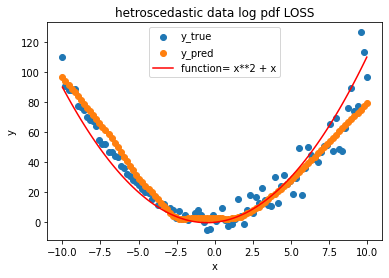

In [234]:
plt.scatter(x, y, label= 'y_true')
plt.scatter(x, forward(params, x), label='y_pred')
plt.plot(x, x**2 + x, 'r', label='function= x**2 + x')
plt.legend();
plt.xlabel('x')
plt.ylabel('y')
plt.title('hetroscedastic data log pdf LOSS')
plt.show()

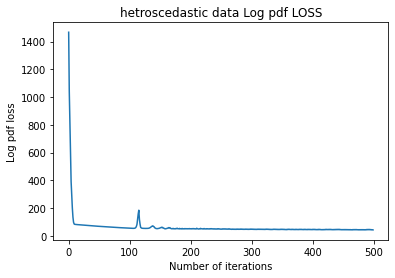

In [235]:
epo_list = [i for i in range(num_epochs)]
plt.plot(epo_list, loss_list)
plt.xlabel('Number of iterations')
plt.ylabel('Log pdf loss')
plt.title('hetroscedastic data Log pdf LOSS')
plt.show()

### for tfp loss

In [236]:
params = init_mlp_params([1, 10, 10, 1], key)

print(jax.tree_map(lambda x:x.shape, params))
num_epochs = 500
loss_list = []
for _ in range(num_epochs):
    loss, params = update_tfp(params, x, y)
    loss_list.append(loss)

[{'biases': (10,), 'weights': (1, 10)}, {'biases': (10,), 'weights': (10, 10)}, {'biases': (1,), 'weights': (10, 1)}]


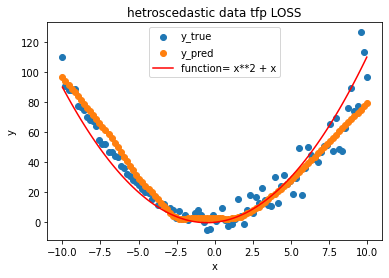

In [237]:
plt.scatter(x, y, label= 'y_true')
plt.scatter(x, forward(params, x), label='y_pred')
plt.plot(x, x**2 + x, 'r', label='function= x**2 + x')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('hetroscedastic data tfp LOSS')
plt.show()

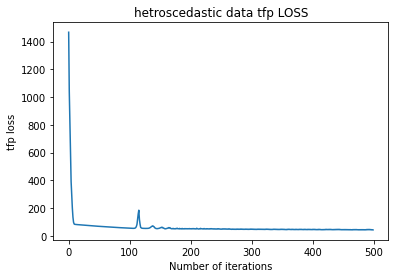

In [238]:
epo_list = [i for i in range(num_epochs)]
plt.plot(epo_list, loss_list)
plt.xlabel('Number of iterations')
plt.ylabel('tfp loss')
plt.title('hetroscedastic data tfp LOSS')
plt.show()

## learning variance in homoscedastic data

In [270]:
# loss using tensor flow probability distribution 
def loss_tfp(theta, x, y):

    out = forward(theta, x)
    y_hat = out[:,0]
    variance = out[:,1]
    dist = tfp.distributions.Normal(y_hat, jnp.sqrt(variance))
    res = -jnp.mean(dist.log_prob(y)) 
    return res 

In [271]:
# Homoscedastic noise
x = jnp.linspace(-10, 10, 100).reshape(100,1)
mu = 0
std = 5
key = jax.random.PRNGKey(5)
es = mu + std * jax.random.normal(key, (100,1))
y = x **2 + es + x

In [272]:
# using tfp loss
params = init_mlp_params([1, 10, 10, 2], key)

print(jax.tree_map(lambda x:x.shape, params))
num_epochs = 500
loss_list = []
for _ in range(num_epochs):
    loss, params = update_tfp(params, x, y)
    loss_list.append(loss)

[{'biases': (10,), 'weights': (1, 10)}, {'biases': (10,), 'weights': (10, 10)}, {'biases': (2,), 'weights': (10, 2)}]


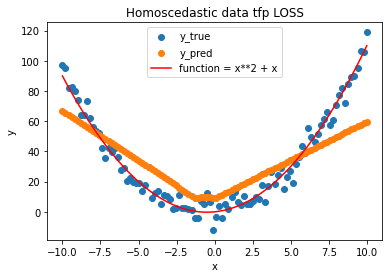

In [273]:
plt.scatter(x, y, label='y_true')
out = forward(params, x)
# print(out[0])
y_pred = out[:,0]
plt.scatter(x,y_pred, label='y_pred')
plt.plot(x, x**2 + x, 'r', label= 'function = x**2 + x')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Homoscedastic data tfp LOSS')
plt.show()

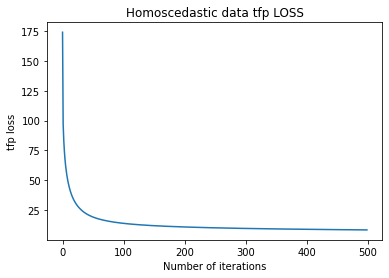

In [274]:
epo_list = [i for i in range(num_epochs)]
plt.plot(epo_list, loss_list)
plt.xlabel('Number of iterations')
plt.ylabel('tfp loss')
plt.title('Homoscedastic data tfp LOSS')
plt.show()

## learning variance in homoscedastic data

In [275]:
# Hetroscedastic noise
x = jnp.linspace(-10, 10, 100).reshape(100,1)
mu = 0
std = 5
key = jax.random.PRNGKey(5)
es = mu + std * jax.random.normal(key, (100,1))
y = x **2  + x *es

In [304]:
# using tfp loss
params = init_mlp_params([1, 10, 10, 2], key)

print(jax.tree_map(lambda x:x.shape, params))
num_epochs = 500
loss_list = jnp.array([])
for i in range(num_epochs):
    loss, params = update_tfp(params, x, y)
    if i%10==0:
      loss_list = jnp.append(loss_list, loss)

[{'biases': (10,), 'weights': (1, 10)}, {'biases': (10,), 'weights': (10, 10)}, {'biases': (2,), 'weights': (10, 2)}]


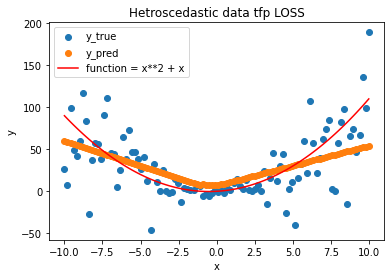

In [305]:
plt.scatter(x, y, label='y_true')
out = forward(params, x)
# print(out[0])
y_pred = out[:,0]
plt.scatter(x,y_pred, label='y_pred')
plt.plot(x, x**2 + x, 'r', label= 'function = x**2 + x')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Hetroscedastic data tfp LOSS')
plt.show()

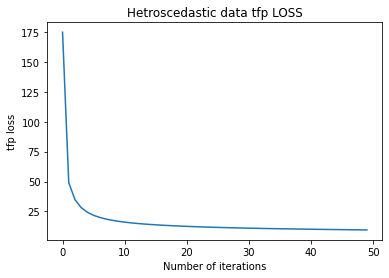

In [306]:
epo_list = [i for i in range(len(loss_list))]
plt.plot(epo_list, loss_list)
plt.xlabel('Number of iterations')
plt.ylabel('tfp loss')
plt.title('Hetroscedastic data tfp LOSS')
plt.show()